# Analyze surface observations for evidence of the stability feedback
Proof of concept for the LEaDing Fellows proposal

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

# Original Swamp Angel observations
dirDataRaw = dirPre + 'GroundObs/SenatorBeck/Raw'

## Open data

In [3]:
os.chdir(dirData)
SWA = xr.open_dataset('SWA.ModTsfc.nc')
SNQ = xr.open_dataset('SNQ.ModTsfc.nc')
CDP = xr.open_dataset('CDP.ModTsfc.nc')

In [4]:
# --------------------------------------------------------------------------------------------
# Add bulk stability measure to each site
RiBulk,_,_ = turbpy.bulkRichardson(SWA.Tair + 273.15, SWA.Tsrf + 273.15, SWA.WIND, 6 - SWA.snowDepth)
SWA['RiBulk'] = RiBulk
RiBulk,_,_ = turbpy.bulkRichardson(SNQ.Tair + 273.15, SNQ.Tsrf + 273.15, SNQ.WIND, 6 - SNQ.snowDepth)
SNQ['RiBulk'] = RiBulk
RiBulk,_,_ = turbpy.bulkRichardson(CDP.Tair + 273.15, CDP.Tsrf + 273.15, CDP.WIND, 6 - CDP.snowDepth)
CDP['RiBulk'] = RiBulk

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in multiply
  if not reflexive


In [5]:
# Other accounting
SWA_daily = SWA.resample(how='mean', freq='d', dim='time')
SNQ_daily = SNQ.resample(how='mean', freq='d', dim='time')
CDP_daily = CDP.resample(how='mean', freq='d', dim='time')

# Dictionaries for iterating
met = {'SWA': SWA,
       'SNQ': SNQ,
       'CDP': CDP}

metDaily = {'SWA_daily': SWA_daily,
            'SNQ_daily': SNQ_daily,
            'CDP_daily': CDP_daily}

## Functions

In [6]:
def clearSkyIndex(eWaterVapor, airTemp, obsLW):
    '''
    Marty, C., and R. Philipona (2000), The Clear-Sky Index to separate Clear-Sky from Cloudy-Sky
        Situations in Climate Research, Geophys. Res. Lett., 27(17), 2649–2652.
    
    eWaterVapor = water vapor in [Pa]
    airTemp = screen temp in [K]
    obsLW = observed LW in [Wm-2]
    '''
    
    # Observed emissivity
    epsilon_A = obsLW / (5.67 * 10 ** (-8) * airTemp ** 4)
    
    # Parameters (empirically derived in citation)
    epsilon_AD = 0.22
    k = 0.455
    
    # Empirically-derived longwave
    epsilon_AC = epsilon_AD + k * (eWaterVapor / airTemp) ** (1 / 8)
    empLW = epsilon_AC * (5.67 * 10 ** (-8) * airTemp ** 4)
    
    # Cloud index
    CSI = epsilon_A / epsilon_AC
    
    # Return logical. CSI > 1 => cloud present and vice versa
    cloudIndex = (CSI <= 1)
    return cloudIndex, CSI, empLW

In [7]:
# 2d histograms of longwave and surface temperature, categorized accoding to a threshold value
def TsfcLWdwn_indPlot(dat, indVar, indVal, titleLarge, titleSmall, supTitle, vmin=None, vmax=None):
    indLarge = dat[indVar] > indVal
    indSmall = dat[indVar] < indVal
    
    # parameters
    ymin = 150
    ymax = 350
    xmin = -30
    xmax = 0
    dx = 1
    dy = 10
    fig, ax = plt.subplots(1, 2)
    
    # Above threshold plot
    hist2d(dat.snowTs[indLarge].values, dat.LWdwn[indLarge].values, ax[0],
           xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, dx=dx, dy=dy, cmap=None)
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_title(titleLarge)

    # Below threshold plot
    hist2d(dat.snowTs[indSmall].values, dat.LWdwn[indSmall].values, ax[1],
           xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, dx=dx, dy=dy, cmap=None, vmin=vmin, vmax=vmax)
    ax[1].set_ylim(ymin, ymax)
    ax[1].set_xlim(xmin, xmax)
    ax[1].set_title(titleSmall)
    
    fig.suptitle(supTitle)

In [8]:
def hist2d(xDat, yDat, ax, xmin=None, xmax=None, ymin=None, ymax=None, dx=None, dy=None, cmap=None, vmin=5, vmax=200):
    # Clean up key parameters
    if not cmap:
        cmap = kgraph.cmap_discretize(cm.Blues, 15)
    if not xmin:
        xmin = np.nanmin(xDat)
    if not xmax:
        xmax = np.nanmax(xDat)
    if not ymin:
        ymin = np.nanmin(yDat)
    if not ymax:
        ymax = np.nanmax(yDat)
    if not dx:
        dx = np.round((xmax - xmin) / 10)
    if not dy:
        dy = np.round((ymax - ymin) / 10)
    
    # Construct bins
    bins = (np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy))
    
    # indices of real values
    ind = np.nonzero(~np.isnan(xDat) & ~np.isnan(yDat)) 
    
    # Plot
    ax.hist2d(xDat[ind], yDat[ind], bins=bins, cmap=cmap, vmin=vmin, vmax=vmax)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive


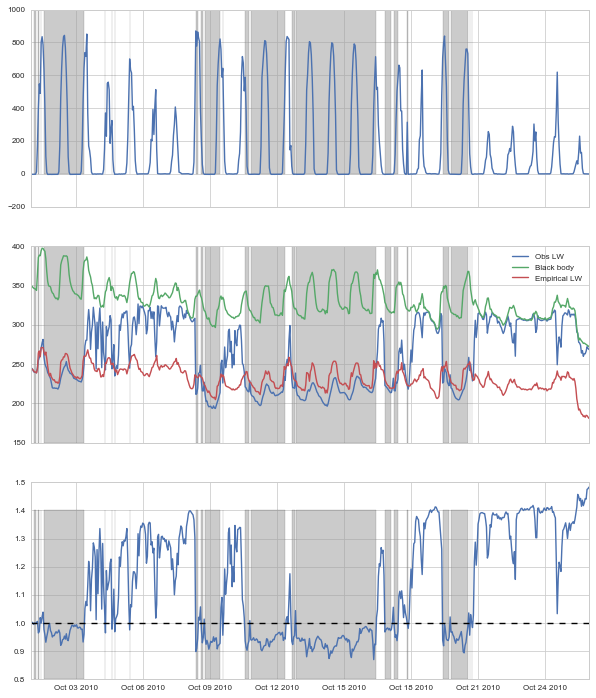

In [9]:
# Cloud detection and empirically-derived LW -- SWA

# First, we need water vapor pressure in Pa. Use the Teten's formula to estimate
satWaterVaporPress = 0.61078 * np.exp( (17.27 * (SWA.Tair)) / (SWA.Tair + 237.3))
waterVaporPress = satWaterVaporPress * (SWA.RH / 100) * 1000

# Cloud detection
SWA['cloudIndex'], SWA['CSI'], SWA['empLW'] = clearSkyIndex(waterVaporPress,
                                                            SWA.Tair.values + 273.15,
                                                            SWA.LWdwn.values)

# Let's just make sure my cloud index performs as I would expect:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
axes = axes.flatten()


# Let's look at October 2005
d = pd.date_range(start='2010-10-1', freq='H', periods=25 * 24)
SWAsub = SWA.loc[{'time': d}]

# Shortwave
ax = axes[0]
ax.plot(SWAsub.time, SWAsub.SWdwn)
ax.fill_between(SWAsub.time.values, 0, 1000, where=SWAsub.cloudIndex, alpha=0.5, facecolor='0.6')

# Longwave
ax = axes[1]
ax.plot(SWAsub.time, SWAsub.LWdwn, label='Obs LW')
ax.plot(SWAsub.time, (SWAsub.Tair + 273.15) ** (4) * 5.67 * 10 ** (-8), label='Black body')
ax.plot(SWAsub.time, SWAsub.empLW, label='Empirical LW')
ax.fill_between(SWAsub.time.values, 150, 400, where=SWAsub.cloudIndex, alpha=0.5, facecolor='0.6')
ax.legend(loc='best')

# Clouds
ax = axes[2]
ax.plot(SWAsub.time, SWAsub.CSI)
ax.plot([SWAsub.time[0].values, SWAsub.time[-1].values], [1, 1], 'k--')
ax.fill_between(SWAsub.time.values, 0.8, 1.4, where=SWAsub.cloudIndex, alpha=0.5, facecolor='0.6')

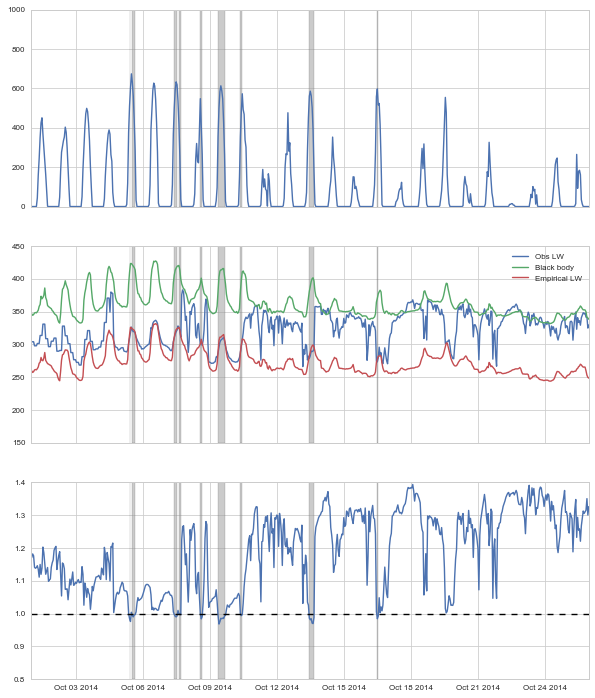

In [10]:
# Cloud detection and empirically-derived LW -- SNQ

# First, we need water vapor pressure in Pa. Use the Teten's formula to estimate
satWaterVaporPress = 0.61078 * np.exp( (17.27 * (SNQ.Tair)) / (SNQ.Tair + 237.3))
waterVaporPress = satWaterVaporPress * (SNQ.RH / 100) * 1000

# Cloud detection
SNQ['cloudIndex'], SNQ['CSI'], SNQ['empLW'] = clearSkyIndex(waterVaporPress,
                                                            SNQ.Tair.values + 273.15,
                                                            SNQ.LWdwn.values)

# Let's just make sure my cloud index performs as I would expect:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
axes = axes.flatten()

# Let's look at October 2014
d = pd.date_range(start='2014-10-1', freq='H', periods=25 * 24)
SNQsub = SNQ.loc[{'time': d}]

# Shortwave
ax = axes[0]
ax.plot(SNQsub.time, SNQsub.SWdwn)
ax.fill_between(SNQsub.time.values, 0, 1000, where=SNQsub.cloudIndex, alpha=0.5, facecolor='0.6')

# Longwave
ax = axes[1]
ax.plot(SNQsub.time, SNQsub.LWdwn, label='Obs LW')
ax.plot(SNQsub.time, (SNQsub.Tair + 273.15) ** (4) * 5.67 * 10 ** (-8), label='Black body')
ax.plot(SNQsub.time, SNQsub.empLW, label='Empirical LW')
ax.fill_between(SNQsub.time.values, 150, 450, where=SNQsub.cloudIndex, alpha=0.5, facecolor='0.6')
ax.legend(loc='best')

# Clouds
ax = axes[2]
ax.plot(SNQsub.time, SNQsub.CSI)
ax.plot([SNQsub.time[0].values, SNQsub.time[-1].values], [1, 1], 'k--')
ax.fill_between(SNQsub.time.values, 0.8, 1.4, where=SNQsub.cloudIndex, alpha=0.5, facecolor='0.6')

Seems to work at Snoqualmie, but it really highlights how rare clear days are at that site.

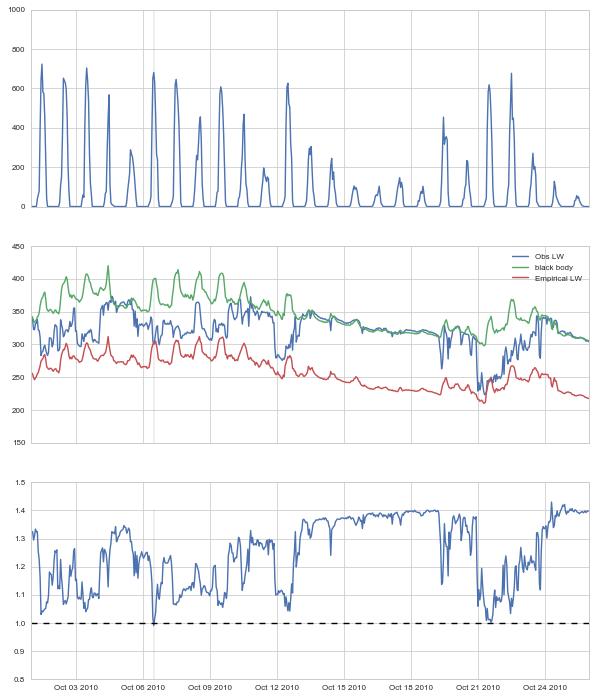

In [11]:
# Cloud detection and empirically-derived LW -- CDP

# First, we need water vapor pressure in Pa. Use the Teten's formula to estimate
satWaterVaporPress = 0.61078 * np.exp( (17.27 * (CDP.Tair)) / (CDP.Tair + 237.3))
waterVaporPress = satWaterVaporPress * (CDP.RH / 100) * 1000

# Cloud detection
CDP['cloudIndex'], CDP['CSI'], CDP['empLW'] = clearSkyIndex(waterVaporPress,
                                                            CDP.Tair.values + 273.15,
                                                            CDP.LWdwn.values)

# Let's just make sure my cloud index performs as I would expect:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
axes = axes.flatten()

# Let's look at October 2010
d = pd.date_range(start='2010-10-1', freq='H', periods=25 * 24)
CDPsub = CDP.loc[{'time': d}]

# Shortwave
ax = axes[0]
ax.plot(CDPsub.time, CDPsub.SWdwn)
ax.fill_between(CDPsub.time.values, 0, 1000, where=CDPsub.cloudIndex, alpha=0.5, facecolor='0.6')

# Longwave
ax = axes[1]
ax.plot(CDPsub.time, CDPsub.LWdwn, label='Obs LW')
ax.plot(CDPsub.time, (CDPsub.Tair + 273.15) ** (4) * 5.67 * 10 ** (-8), label='black body')
ax.plot(CDPsub.time, CDPsub.empLW, label='Empirical LW')
ax.fill_between(CDPsub.time.values, 150, 400, where=CDPsub.cloudIndex, alpha=0.5, facecolor='0.6')
ax.legend(loc='best')

# Clouds
ax = axes[2]
ax.plot(CDPsub.time, CDPsub.CSI)
ax.plot([CDPsub.time[0].values, CDPsub.time[-1].values], [1, 1], 'k--')
ax.fill_between(CDPsub.time.values, 0.8, 1.4, where=CDPsub.cloudIndex, alpha=0.5, facecolor='0.6')

Yay! Finally for the cloud indexing to qualitatively work at the Swamp Angel Study Plot. Grey is periods that are determined cloud free by the clear-sky index method of Marty and Philipona. Its a very fragile method, so I'm not putting a huge amount of faith in it at the moment.

I haven't screened at all for periods of snow covered radiometers. Previous work has estimated that the radiometer dome at SWA is covered by snow ~60% of the time during the winter [Lapo et al. 2015].

Lesson learned in this work: the cloud discrmination doesn't work at CDP. My guess is the maritime environment really messes with the empirical longwave algorithm. Previous work has shown that the Brutsaert method is substantially negatively biased. The negative bias became super obvious at CDP. This is also a known problem at SNQ. Future cloud discrimination will need something more robust. I'm thinking that just taking the ratio of $Q_{li} / \sigma T_{air}^4$ may be fairly robust to local climate. If the ratio converges near one -> clouds are present. Ratio's less than 1 by some amount are more likely to be cloud free.

# Screen LWdwn vs Tsfc for potential regimes

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


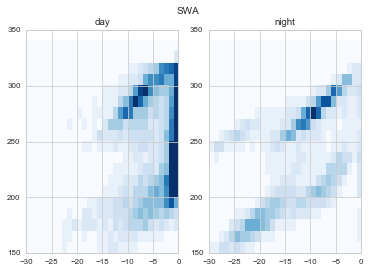

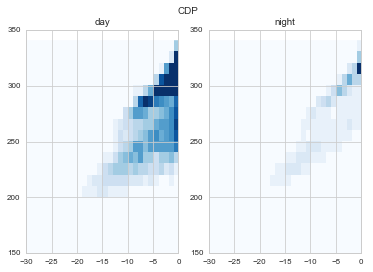

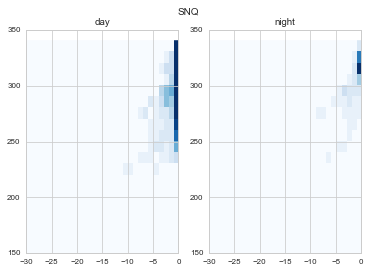

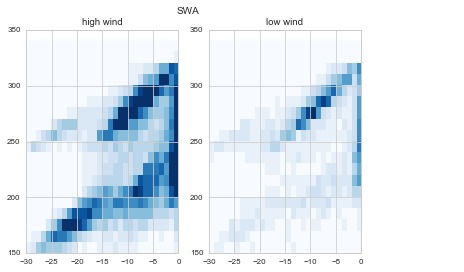

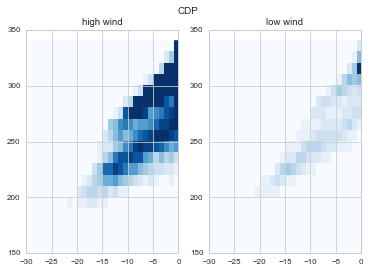

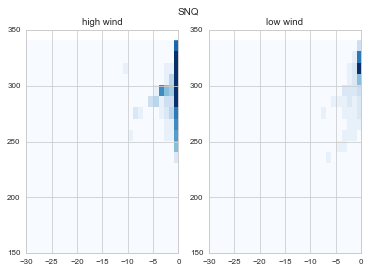

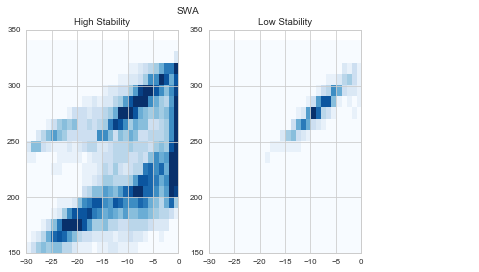

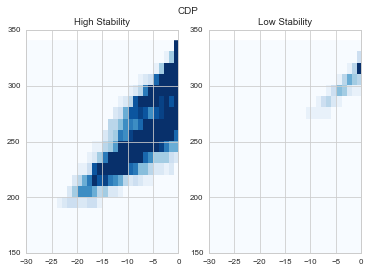

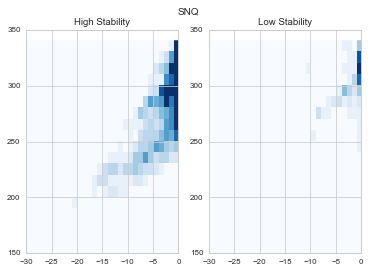

In [12]:
# Night vs Day
for stat in met:
    TsfcLWdwn_indPlot(met[stat], 'SWdwn', 10, 'day', 'night', stat)
    
# Wind threshold
for stat in met:
    TsfcLWdwn_indPlot(met[stat], 'WIND', .5, 'high wind', 'low wind', stat)

# Stability
for stat in met:
    TsfcLWdwn_indPlot(met[stat], 'RiBulk', 0.2, 'High Stability', 'Low Stability', stat)


These graphs do suggest that there does exist different regimes in the LWdwn - Tsfc relationship. Let's try rebinning and explicitly look at only night time values. Categorize according to stability.

Note: they are all missing a colorbar... range is 5 to 200. Saturated blue is 200.

In [20]:
# Turn into 2d hist
def TsfcLWdwn_indPlot_day(dat, indVar, indVal, titleLarge, titleSmall, supTitle, vmin=None, vmax=None):
    indLarge = (dat[indVar] > indVal) & (dat.SWdwn < 10)
    indSmall = (dat[indVar] < indVal) & (dat.SWdwn < 10)
    
    # parameters
    ymin = 150
    ymax = 350
    xmin = -30
    xmax = 0
    dx = 1
    dy = 10
    fig, ax = plt.subplots(1, 2, figsize=(8, 2))
    
    # Above threshold plot
    hist2d(dat.snowTs[indLarge].values, dat.LWdwn[indLarge].values, ax[0],
           xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, dx=dx, dy=dy, cmap=None)
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylabel('$Q_{li} Wm^{-2}$')
    ax[0].set_xlabel('$T_{sfc} (^{\circ} C)$')
    ax[0].set_title(titleLarge)

    # Below threshold plot
    hist2d(dat.snowTs[indSmall].values, dat.LWdwn[indSmall].values, ax[1],
           xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, dx=dx, dy=dy, cmap=None, vmin=vmin, vmax=vmax)
    ax[1].set_ylim(ymin, ymax)
    ax[1].set_xlim(xmin, xmax)
    ax[1].set_xlabel('$T_{sfc} (^{\circ} C)$')
    ax[1].set_title(titleSmall)
    
#     fig.suptitle(supTitle)
    return fig

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


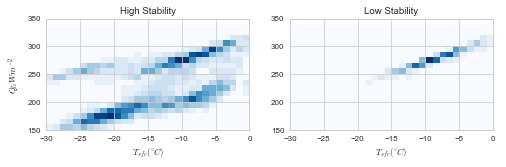

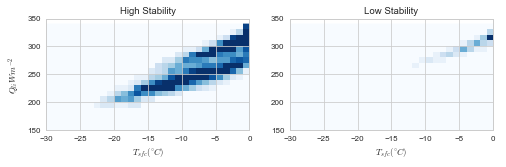

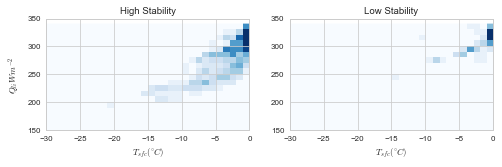

In [21]:
os.chdir(dirPrint)
for stat in met:
    f = TsfcLWdwn_indPlot_day(met[stat], 'RiBulk', 0.2, 'High Stability', 'Low Stability', stat)
    f.savefig('ModTsfc.ObsStabFeed_Regimes.' + stat + '.pdf')

Getting closer to what I expected. There still appears to be populations of points in the high stability case. My guess here is that cloud cover is destroying a possibly decoupled boundary layer. Let's check

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


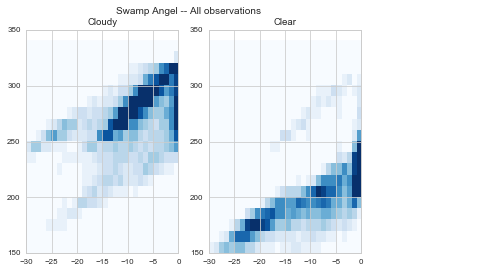

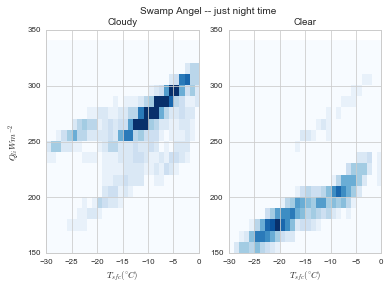

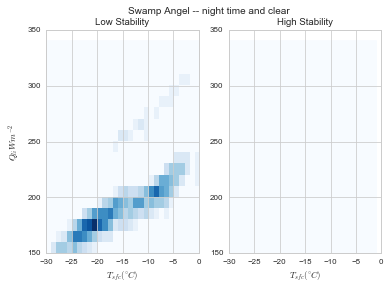

In [26]:
TsfcLWdwn_indPlot(SWA, 'CSI', 1, 'Cloudy', 'Clear', 'Swamp Angel -- All observations')

TsfcLWdwn_indPlot_day(SWA, 'CSI', 1, 'Cloudy', 'Clear', 'Swamp Angel -- just night time')

SWAsub = SWA.where(SWA.cloudIndex)
TsfcLWdwn_indPlot_day(SWAsub, 'RiBulk', 0.2, 'Low Stability', 'High Stability', 'Swamp Angel -- night time and clear')

Ok, so that lower blob of points in the above plots is a result of cloudy vs clear. Interestingly, it doesn't appear like there are any low stability events from this perspective. Hmmmm...

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


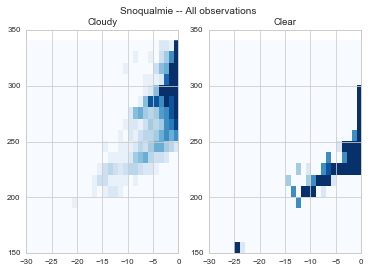

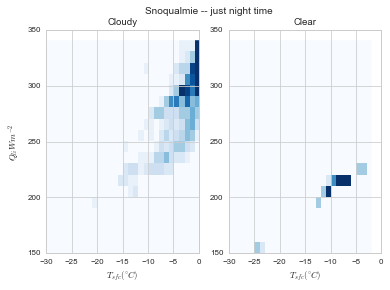

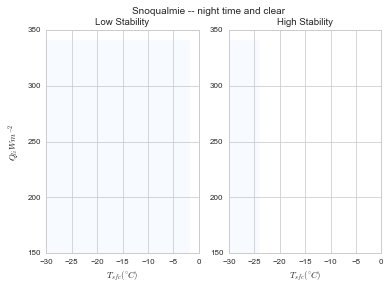

In [36]:
TsfcLWdwn_indPlot(SNQ, 'CSI', 1, 'Cloudy', 'Clear', 'Snoqualmie -- All observations', vmin=5, vmax=10)

TsfcLWdwn_indPlot_day(SNQ, 'CSI', 1, 'Cloudy', 'Clear', 'Snoqualmie -- just night time', vmin=5, vmax=10)

SNQsub = SNQ.where(SNQ.cloudIndex)
TsfcLWdwn_indPlot_day(SNQsub, 'RiBulk', 0.2,
                      'Low Stability', 'High Stability', 'Snoqualmie -- night time and clear',
                      vmin=5, vmax=10)

huh... didn't realize that clear nights are so rare at Snoqualmie. Either that or the empirical longwave really just falls apart at this maritime site. I'm willing to bet its the empirical longwave because I have been there on nights when its clear and the surface is much colder than the atmosphere...